In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dalex as dx
from copy import deepcopy, copy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
import warnings
warnings.filterwarnings('ignore')
import pickle
import sklearn.metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report, accuracy_score, balanced_accuracy_score, precision_score, recall_score

In [3]:
def test_models(data_test, target_test, pplns):
    """
    Funckja przyjmuje testowe dane oraz listę wartości zmiennej objaśnianej i listę obiektów typu Pipeline do sprawdzenia oraz wizualizacji ich skuteczności.
    Rezultatem jej działaniea jest wypisanie wartości średnich geometrycznych oraz prezentacja wykresów: ROC AUC i precision-recall curve
    """
    i=0
    precision = [0]*len(pplns)
    recall = [0]*len(pplns)
    listap = [0]*len(pplns)
    tpr = [0]*len(pplns)
    fpr = [0]*len(pplns)
    listauc = [0]*len(pplns)
    listaucpred = [0]*len(pplns)
    names = [0]*len(pplns)
    for pipe in pplns:
        pipename = pipe.steps[0][0] if pipe.steps[0][0] != 'standardscaler' else pipe.steps[1][0]
        names[i] = pipename
        y_pred = pipe.predict(data_test)
        #print("Classification report of model {0}:\n{1}".format(pipename, classification_report(target_test, y_pred)))
        print('Accuracy score for {0} model: {1:.2f}%\n'.format(pipename, accuracy_score(target_test, y_pred)*100))
        probabilities = pipe.predict_proba(data_test)[:, 1] 
        precision[i] = dict()
        recall[i] = dict()
        listap[i] = dict()
        tpr[i] = dict()
        fpr[i] = dict()
        listauc[i] = dict()
        fpr[i], tpr[i], _ = roc_curve(target_test, probabilities)
        listauc[i] = auc(fpr[i], tpr[i])
        precision[i], recall[i], _ = precision_recall_curve(target_test, probabilities)
        listaucpred[i] = auc(recall[i], precision[i])
        listap[i] = average_precision_score(target_test, probabilities)
        i+=1
    lw = 2
    colors = ['red', 'green', 'blue', 'orange', 'yellow'] ### gdy pipelinow jest wiecej, nalezy rozszerzyc
    labels = []
    lines = []
    ##Drugi wykres - ROC
    plt.figure(figsize=(10, 6))
    for j in range(i):
        plt.plot(fpr[j], tpr[j], color=colors[j], lw=lw, label='{0} ROC curve (area = {1:.2f})'.format(names[j], listauc[j]))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
knn = pickle.load(open("Modele/knn", 'rb'))
nb = pickle.load(open("Modele/naive_bayes", 'rb'))
rf = pickle.load(open("Modele/random_forest", 'rb'))

In [5]:
df = pd.read_csv('heart_data.csv')

In [6]:
y = df.target.values
x = df.drop(['target'], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2,random_state=0, stratify=y)

In [7]:
ss = StandardScaler()
ss.fit(x_train, y_train) 
p_knn = Pipeline(
    [
        ('standardscaler', ss),
        ('KNN', knn)
    ]
)

p_nb = Pipeline(
    [
        ('Naive Bayes', nb)
    ]
)
p_rf = Pipeline(
    [
        ('Random Forest', rf)
    ]
)
p_svc = Pipeline(
    [
        ('standardscaler', ss),
        ('SVC', SVC( C = 0.5, random_state=1, probability=True))
    ]
)
p_svc.fit(x_train, y_train)
pipelines = [p_knn, p_nb, p_rf, p_svc]

In [8]:
df_cvc = pd.DataFrame(columns=['accuracy','precision','recall', 'roc_auc'])
names = []
for i, model in enumerate(pipelines):
    for metric in df_cvc.columns.values:
        df_cvc.loc[i,metric] = np.mean(cross_val_score(model, x_train, y_train, scoring=metric))
        pipename = model.steps[0][0] if model.steps[0][0] != 'standardscaler' else model.steps[1][0]
    names.append(pipename)
df_cvc.index = names

In [9]:
tree = DecisionTreeClassifier()

param_dist = {"max_depth": randint(3,10),
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

tree_Rcv = RandomizedSearchCV(tree, param_dist, cv=5)
tree_Rcv.fit(x_train, y_train)


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001AE3EC3ED90>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001AE3EB21DC0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001AE3EC3ECD0>})

In [10]:
param_grid = {"max_depth": range(3,10),
              "max_features": range(1, 9),
              "min_samples_leaf": range(1, 9),
              "criterion": ["gini", "entropy"]}

tree_Gcv = GridSearchCV(tree, param_grid, cv = 5)
tree_Gcv.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(3, 10), 'max_features': range(1, 9),
                         'min_samples_leaf': range(1, 9)})

In [11]:
def recall_compare(x, y, ls_pipe):
    for p in ls_pipe:
        pipename = p.steps[0][0] if p.steps[0][0] != 'standardscaler' else p.steps[1][0]
        print('Racall for ' + pipename + ': ' + str(round(recall_score(y, p.predict(x)), 3)))

# Zmienne i zmianny danych 

Korzystaliśmy ze zbioru danych z oficjalnej strony UCI: https://archive.ics.uci.edu/ml/datasets/Heart+Disease 

Zbiór zawiera 303 obserwacji i 13 kolumn.

- age - wiek w latach
- sex - płeć (1 = mężczyzna, 0 = kobieta)
- cp - rodzaj bólu w klatce piersiowej: 
 - cp_ta - typowa dławica
 - cp_aa - nietypowa dławica
 - cp_np - ból niedławicowy
 - cp_a  - brak bólu
- trestbps - spoczynkowe ciśnienie krwi (w mm Hg przy przyjęciu do szpitala) 
- chol - surowica cholesterol w mg / dl 
- fbs - poziom cukru we krwi na czczo > 120 mg/dl (1 = prawda, 0 = fałsz) 
- restecg - spoczynkowe wyniki elektrokardiograficzne: 
 - Wartość 0: normalna 
 - Wartość 1: prawdopodobny przerost lewej komory
- thalach - maksymalne osiągnięte tętno  
- exang - dławica wysiłkowa (1 = tak, 0 = nie) 
- oldpeak - obniżenie ST wywołane wysiłkiem fizycznym w stosunku do odpoczynku 
- slope - nachylenie szczytu ćwiczeń odcinka ST:  
 - slope_up - rosnąco
 - slope_flat - płasko
 - slope_down - malejąco
- ca - liczba głównych naczyń (0-3) zabarwionych podczas badania uwapnienia (wzrost wskazuje rozwój choroby)
- thal - badanie mięśnia sercowego przy użyciu Talu:
 - thal_n - normalny
 - thal_fd - wada naprawiona
 - thal_rd - wada odwrcalna
- target - występowanie chorby wieńcowej (0 - NonCAD 1 - CAD)


Zmiany w danych względem pobranych:

- Zamiana wrtości w zmiennej *cp* pomiędzy typical angina i asymptotic
- Rzutowaliśmy kategorię *restecg = 2* czyli nieprawidłowości w załamaniu T lub odcinku ST na *restecg = 1* z powodu małej liczby wystąpień


W naszym zbiorze dwie zmienne posiadały braki danych:
- zmienna *thal* -  braki danych zastąpiliśmy (thal_n = 1)
- zmienna *ca* - której braki zastąpiliśmy modą (ca = 0)

Pozostałe zmienne kategoryczne (*thal, slope, cp*) zakodowaliśmy metodą One-Hot

# Modelowanie 

Przetestowaliśmy różne modele z których wybraliśmy cztery dające nalepsze wyniki na zbiorze testowym po tuningu. Widać, że dwa pierwsze *KNN* oraz *Naive Bayes* wypadają najlepiej w miarze Accuarcy ale są one glass boxami więc nie będziemy ich używać.  

Accuracy score for KNN model: 91.80%

Accuracy score for Naive Bayes model: 90.16%

Accuracy score for Random Forest model: 86.89%

Accuracy score for SVC model: 86.89%



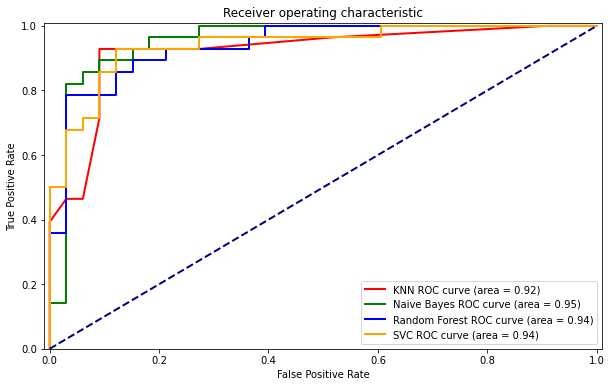

In [12]:
test_models(x_test, y_test, pipelines)

Aby wybrać model postanowiliśmy zbadać *recall* ponieważ w naszym przypadku bardzo istotne jest wyłapywanie osób potencjalnie chorujących na CAD. Wyniki wskazują, że CVS jest faworytem z modeli black boxowych.

In [13]:
recall_compare(x_test, y_test, pipelines)

Racall for KNN: 0.929
Racall for Naive Bayes: 0.893
Racall for Random Forest: 0.786
Racall for SVC: 0.857


Aby upewnić się w naszym wyborze sprawdziliśmy jak sobie radzić będą te modele stosując kroswalidację na różnych metrykach. W tym przypadku SVC nadal jest lepszy od Random Forest.

In [14]:
df_cvc

,accuracy,precision,recall,roc_auc
KNN,0.818367,0.834402,0.756917,0.888199
Naive Bayes,0.801701,0.788725,0.774308,0.856485
Random Forest,0.793367,0.798524,0.737945,0.897547
SVC,0.809779,0.815493,0.756126,0.882832


# Model pojedyńczego drzewa

Postanowiliśmy zrobić też model pojedyńczego drzewa decyzyjnego dzięki któremu łatwiej udało by nam się wyjaśnić jakie zmienne są decydujące w wyniku naszej diagnagnozy. Pomimo, że tuning parametrów nie przyniósł aż tak dobrych wartości recall jak SVC to wydaje się, że dzięki niemu możemy zbudować intuicję co do naszych lepszych modeli. 

In [15]:
print("Tuned Tree Parameter: {}".format(tree_Gcv.best_params_))
print("Tuned Tree Accuracy: {}".format(tree_Gcv.best_score_))

Tuned Tree Parameter: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 7, 'min_samples_leaf': 6}
Tuned Tree Accuracy: 0.8386904761904761


In [16]:
print('Accuracy: ' + str(round(tree_Gcv.best_estimator_.score(x_test, y_test),3)))

Accuracy: 0.836


In [17]:
y_hat = tree_Gcv.predict(x_test)
print("Racall of Tree: " + str(round(recall_score(y_test, y_hat),3)))

Racall of Tree: 0.714


In [19]:
print('Recall in corovalidation:')
print(cross_val_score(tree_Gcv.best_estimator_, x_train, y_train, scoring='recall'))

Recall in corovalidation:
[0.82608696 0.81818182 0.54545455 0.63636364 0.63636364]


Jak widać na wykresie poniżej, zmienna *ca* rozdziela nasz zbiór w zależności od tego czy pacjent posiadał zwapnienie na którymś z narządów. Następnie pojawia się zmianna *thal_rd* której występowanie może wskazywać na wczesne fazy rzwoju choroby w których nie doszło jeszcze z zwapnienia narządów. Powtarza się rówanież zminna *cp*, czyli ból w klatce piersiowej, która jest używana przez lekarzy jako istitny wyznacznik występowania CAD zanim jeszcze podejmie się badania.

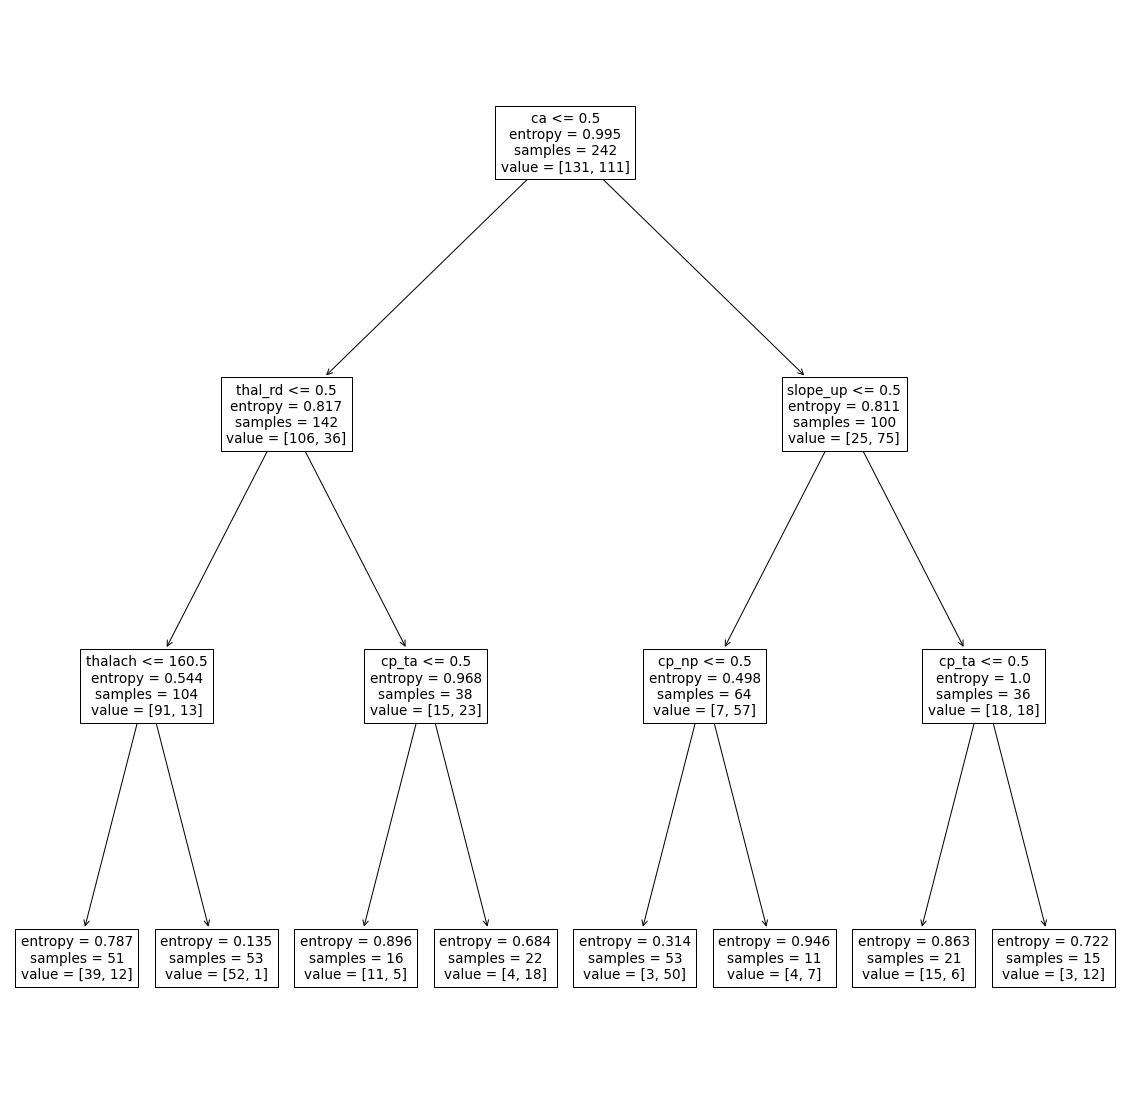

In [46]:
plt.figure(figsize=(20,20))
plot_tree(tree_Gcv.best_estimator_, feature_names=x_train.columns)
plt.show()